
# I. Problem Description

# II. Data Exploration


## 2.1 Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb

In [2]:
train= pd.read_csv('/Users/victoriashi/Desktop/train.csv')
weather= pd.read_csv('/Users/victoriashi/Desktop/weather_train.csv')
building= pd.read_csv('/Users/victoriashi/Desktop/building_metadata.csv')

## 2.2 Data Distribution

In [77]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [78]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [79]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [6]:
print('Shape of train data:',train.shape)
print('Shape of weather train data:', weather.shape)
print('Shape of building meta data:', building.shape)

Shape of train data: (20216100, 4)
Shape of weather train data: (139773, 9)
Shape of building meta data: (1449, 6)


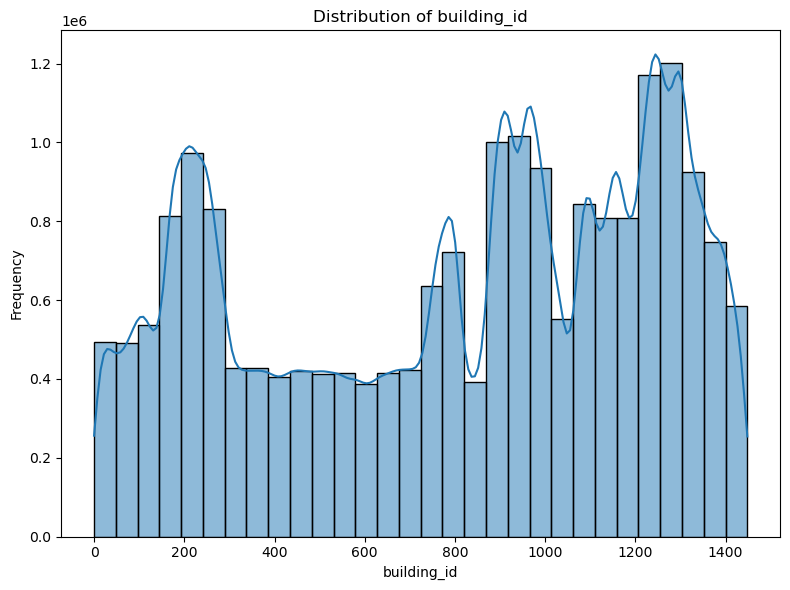

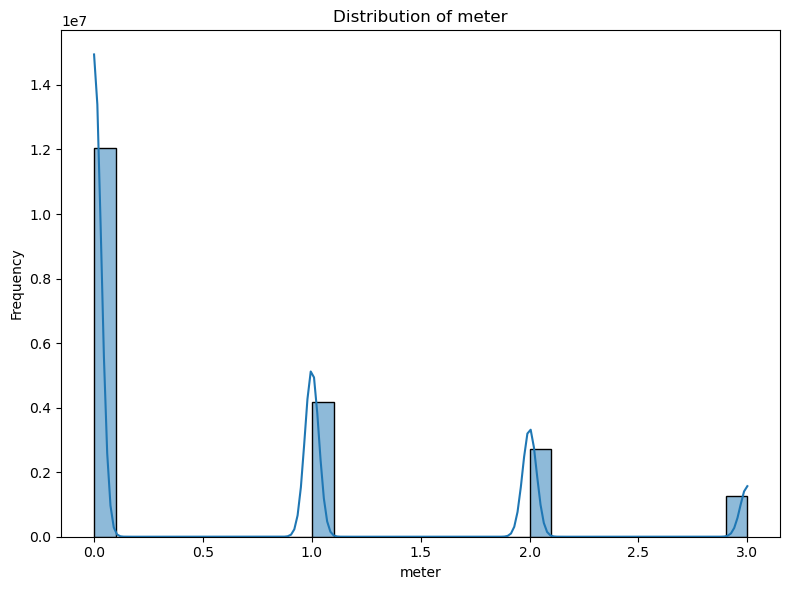

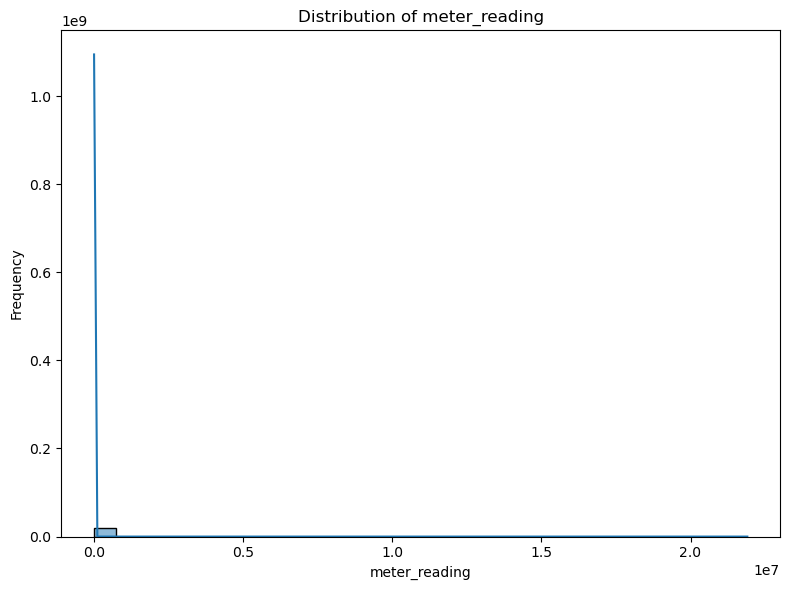

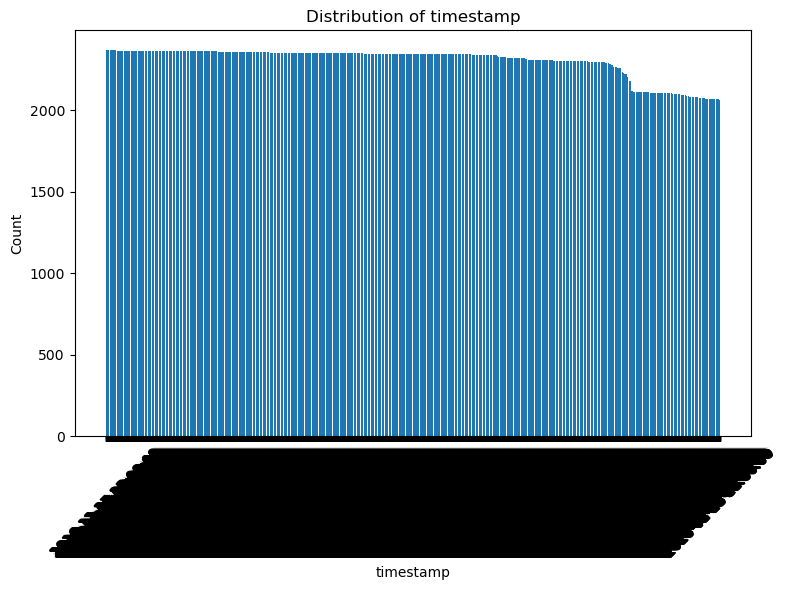

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(data, columns):
    for column in columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(data[column], bins=30, kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

def plot_categorical_distribution_v2(data, columns):
    for column in columns:
        plt.figure(figsize=(8, 6))
        counts = data[column].value_counts()
        plt.bar(counts.index, counts.values)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)  
        plt.tight_layout()
        plt.show()

numerical_columns_train = train.select_dtypes(include=['int64', 'float64']).columns
plot_distribution(train, numerical_columns_train)

categorical_columns_train = train.select_dtypes(include=['object', 'category']).columns
plot_categorical_distribution_v2(train, categorical_columns_train)


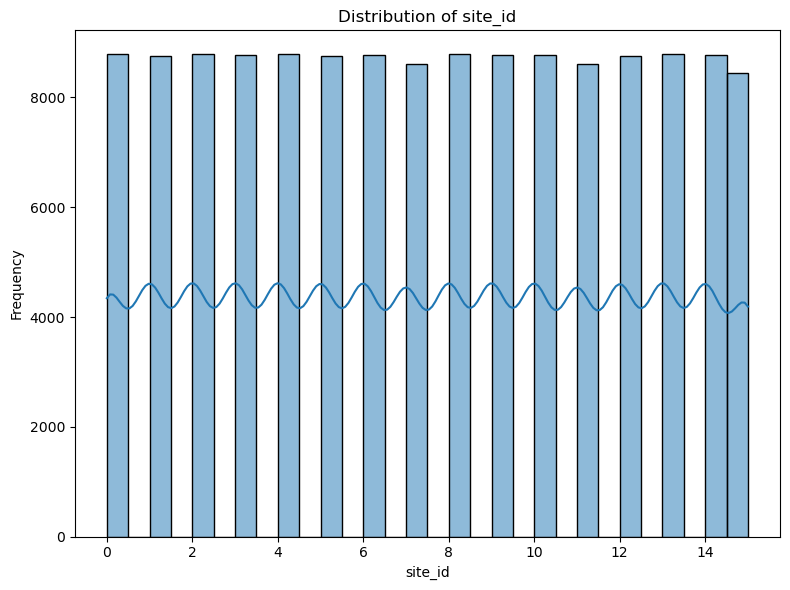

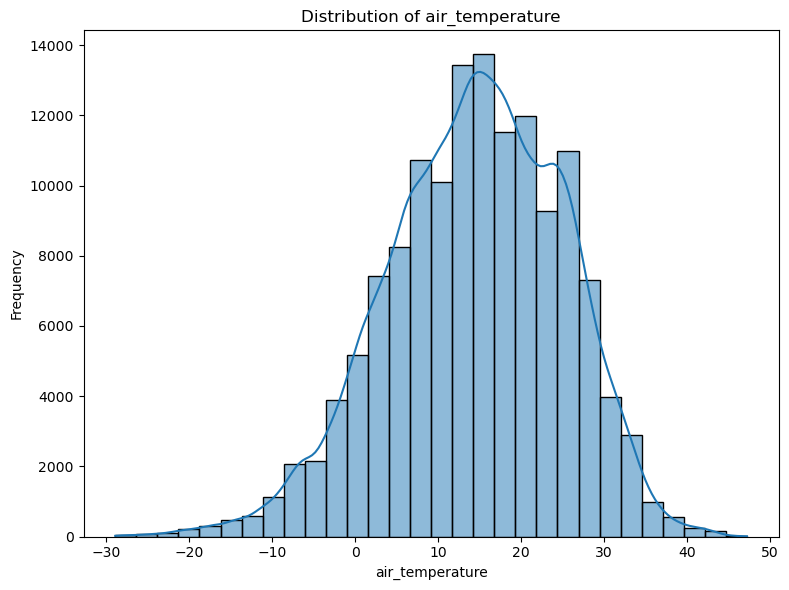

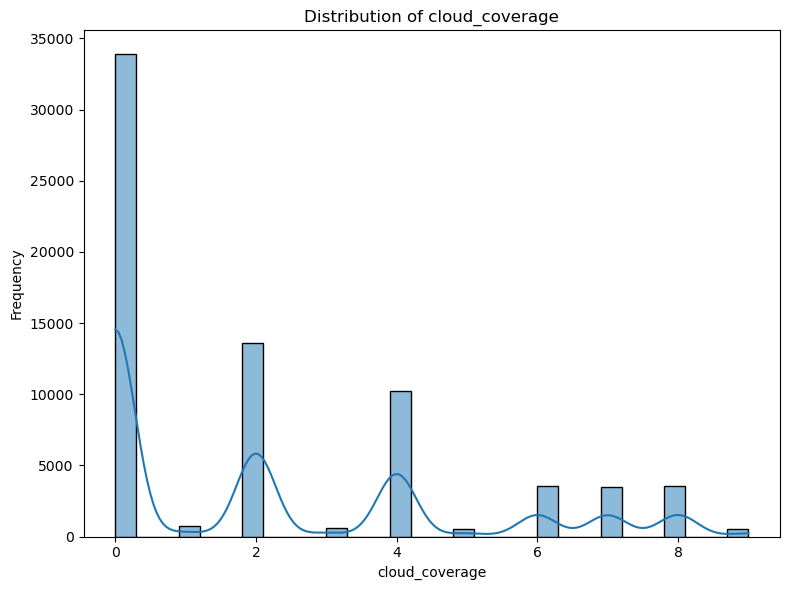

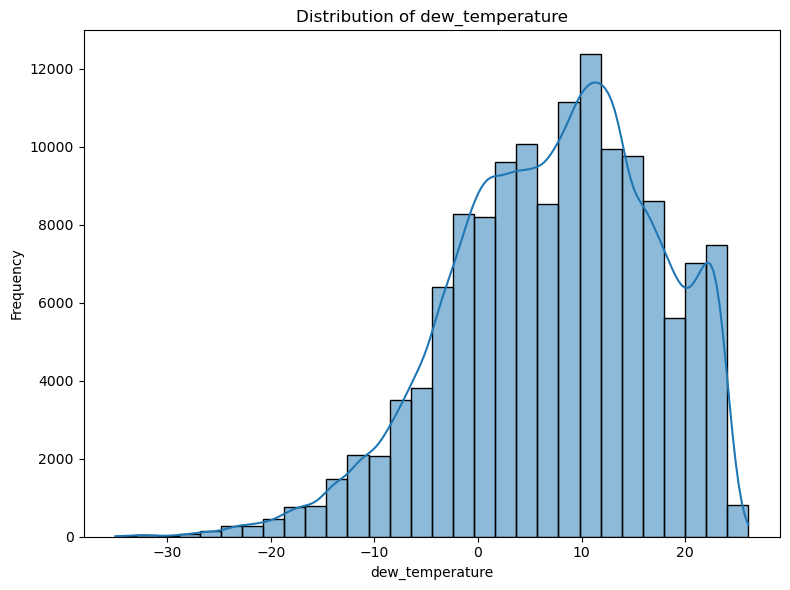

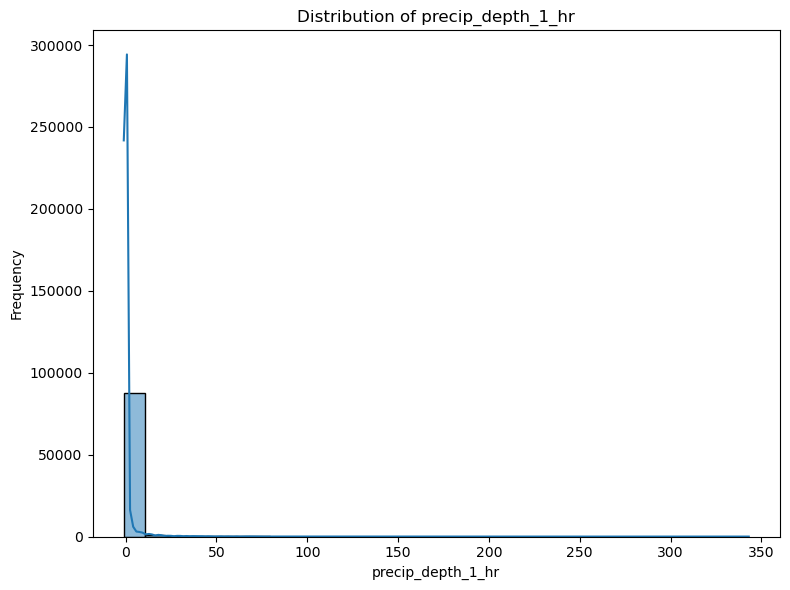

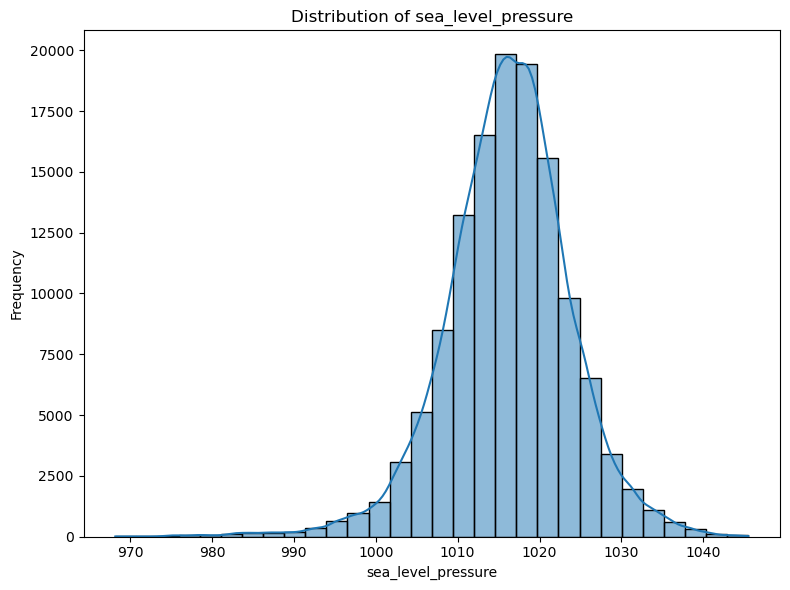

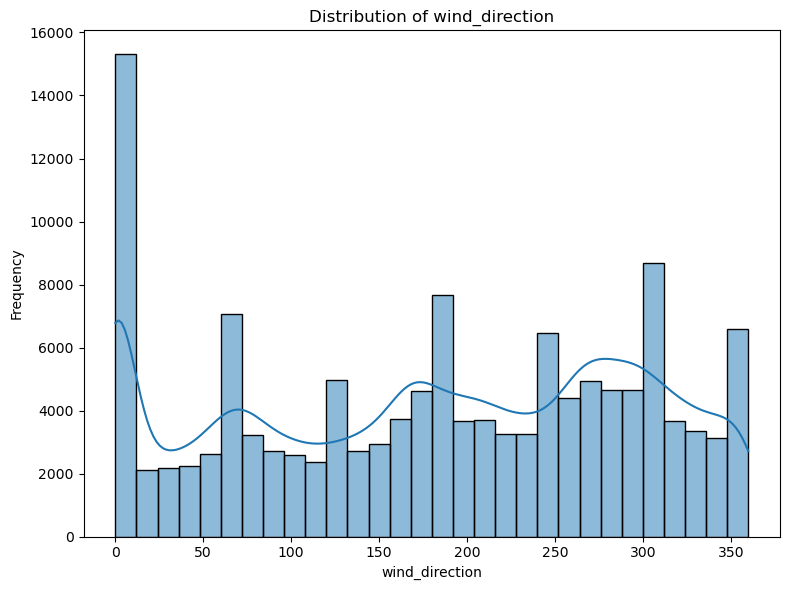

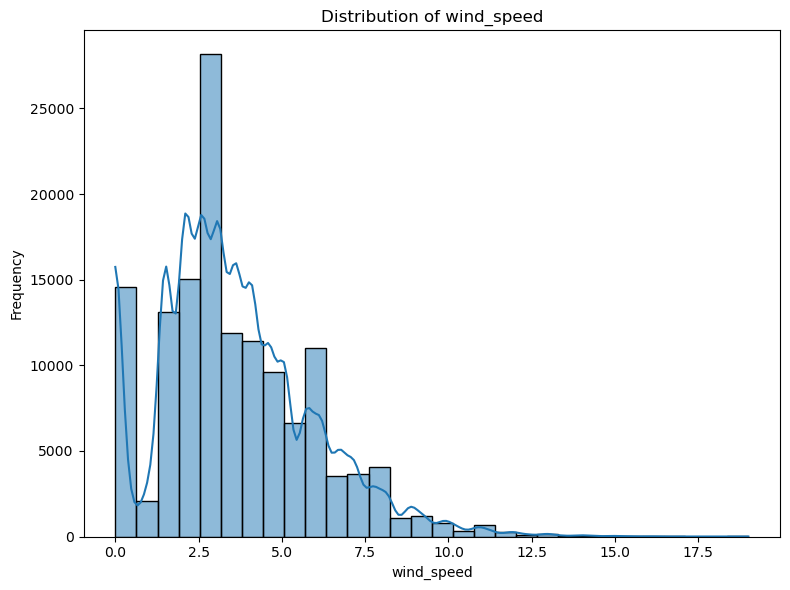

In [9]:
numerical_columns_weather_train = weather.select_dtypes(include=['int64', 'float64']).columns

plot_distribution(weather, numerical_columns_weather_train)

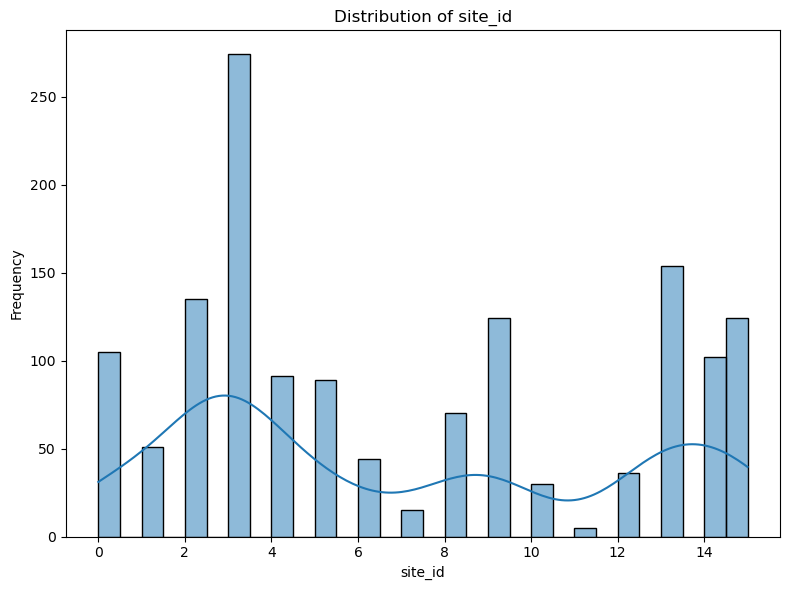

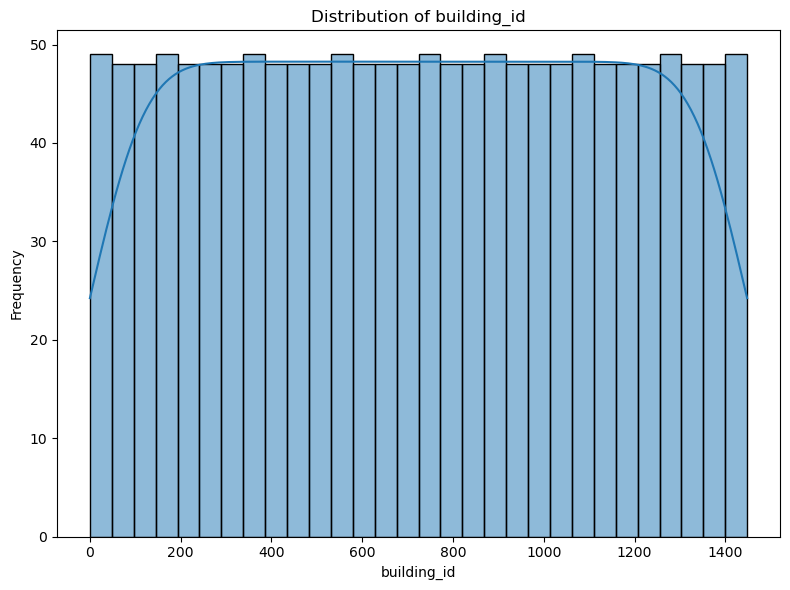

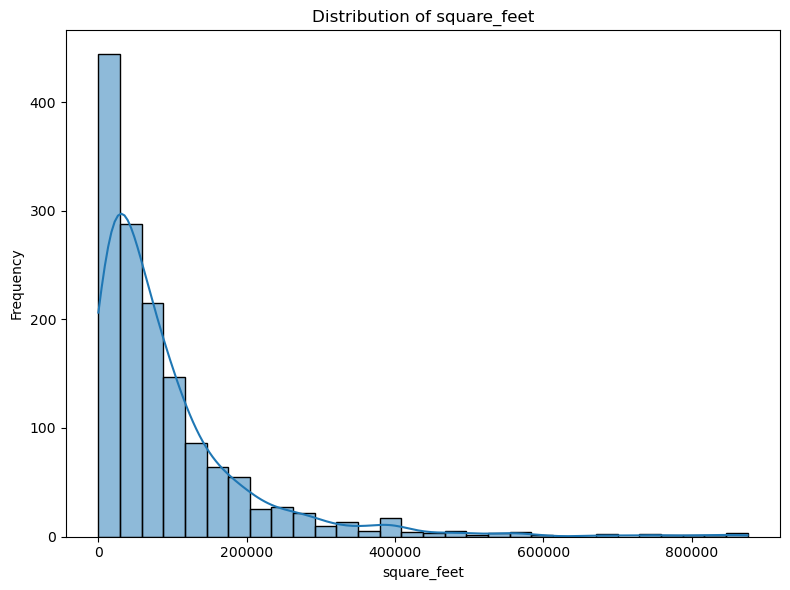

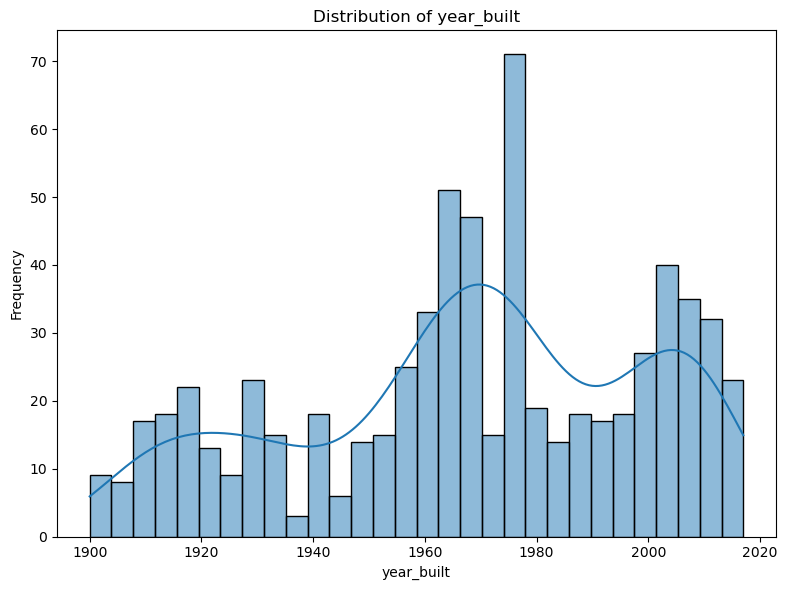

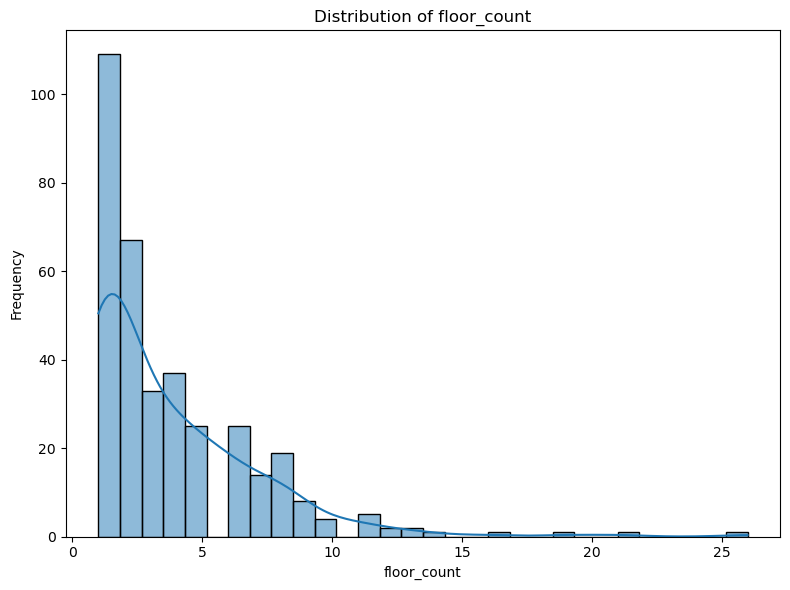

In [10]:
numerical_columns_building_metadata = building.select_dtypes(include=['int64', 'float64']).columns
plot_distribution(building, numerical_columns_building_metadata)

In [11]:
# train
missing_values_train = train.isnull().sum()
missing_values_train_df = pd.DataFrame({'Column': missing_values_train.index, 'Missing Values': missing_values_train.values})
print("Missing values in Train data:")
print(missing_values_train_df)

# weather
missing_values_weather_train = weather.isnull().sum()
missing_values_weather_train_df = pd.DataFrame({'Column': missing_values_weather_train.index, 'Missing Values': missing_values_weather_train.values})
print("\nMissing values in Weather train data:")
print(missing_values_weather_train_df)

# meta
missing_values_building_metadata = building.isnull().sum()
missing_values_building_metadata_df = pd.DataFrame({'Column': missing_values_building_metadata.index, 'Missing Values': missing_values_building_metadata.values})
print("\nMissing values in Building metadata:")
print(missing_values_building_metadata_df)

Missing values in Train data:
          Column  Missing Values
0    building_id               0
1          meter               0
2      timestamp               0
3  meter_reading               0

Missing values in Weather train data:
               Column  Missing Values
0             site_id               0
1           timestamp               0
2     air_temperature              55
3      cloud_coverage           69173
4     dew_temperature             113
5   precip_depth_1_hr           50289
6  sea_level_pressure           10618
7      wind_direction            6268
8          wind_speed             304

Missing values in Building metadata:
        Column  Missing Values
0      site_id               0
1  building_id               0
2  primary_use               0
3  square_feet               0
4   year_built             774
5  floor_count            1094


# III Data Pre-Processing

## 3.1 reduce usage

In [3]:
#https://www.kaggle.com/kernels/scriptcontent/3684066/download

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    #iterating over every column and finding the type of the column
    for col in df.columns:
      if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
      col_type = df[col].dtype
        
        #If the columns is not object
      if col_type != object:
          #Get the minimum and maximum value
            c_min = df[col].min()
            c_max = df[col].max()
            #If the type is int
            if str(col_type)[:3] == 'int':
              #If the min max values lies with thin the range of int8 type then assign the type as int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
              #If the min max values lies with thin the range of int16 type then assign the type as int16 
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
              #If the min max values lies with thin the range of int32 type then assign the type as int32
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
              #If the min max values lies with thin the range of int64 type then assign the type as int64
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
              #If the min max values lies with thin the range of float16 type then assign the type as float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
              #If the min max values lies with thin the range of float32 type then assign the type as float32
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
      else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train= reduce_mem_usage(train, use_float16=True)
weather= reduce_mem_usage(weather, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.84 MB
Decreased by 71.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.59 MB
Decreased by 73.1%


## 3.2 train merge

In [5]:
train_df= train.merge(building, on='building_id', how='left')

In [6]:
train_df=train_df.merge(weather, on=['site_id', 'timestamp'], how='left')

In [16]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [18]:
print("Train data summary:")
print(train_df.describe())
print("\nWeather train data summary:")
print(weather.describe())
print("\nBuilding metadata summary:")
print(building.describe())

Train data summary:
        building_id         meter  meter_reading       site_id   square_feet  \
count  2.021610e+07  2.021610e+07   2.021610e+07  2.021610e+07  2.021610e+07   
mean   7.992780e+02  6.624412e-01   2.117122e+03  7.992232e+00  1.077830e+05   
std    4.269133e+02  9.309921e-01   1.532159e+05  5.099060e+00  1.171424e+05   
min    0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00  2.830000e+02   
25%    3.930000e+02  0.000000e+00   1.830000e+01  3.000000e+00  3.252700e+04   
50%    8.950000e+02  0.000000e+00   7.877500e+01  9.000000e+00  7.270900e+04   
75%    1.179000e+03  1.000000e+00   2.679840e+02  1.300000e+01  1.391130e+05   
max    1.448000e+03  3.000000e+00   2.190470e+07  1.500000e+01  8.750000e+05   

         year_built   floor_count  air_temperature  cloud_coverage  \
count  8.088455e+06  3.506933e+06     2.011944e+07      11390735.0   
mean   1.968277e+03  4.184848e+00              NaN             NaN   
std    3.020815e+01  4.008277e+00     0.000000e+0

## 3.3 Log-transformed 

In [7]:
train_df['meter_reading']=np.log1p(train_df['meter_reading'])

In [8]:
train_df['square_feet']=np.log1p(train_df['square_feet'])

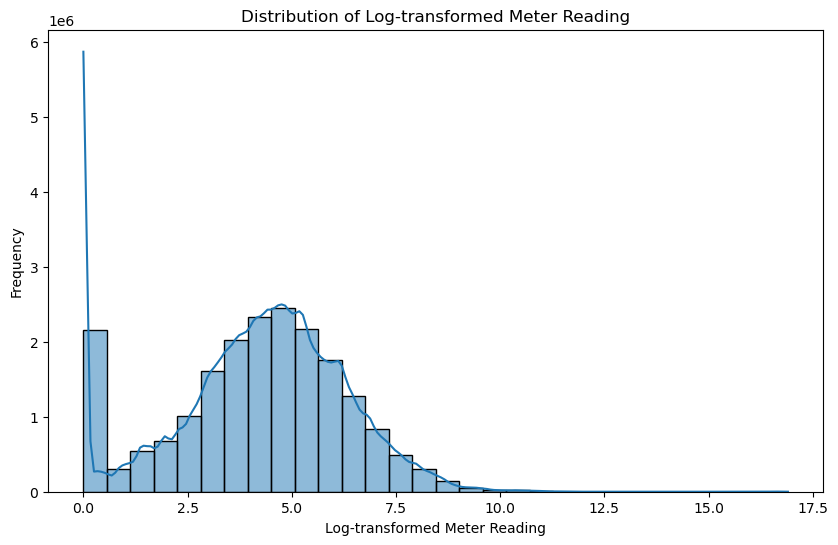

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['meter_reading'], bins=30, kde=True)
plt.title('Distribution of Log-transformed Meter Reading')
plt.xlabel('Log-transformed Meter Reading')
plt.ylabel('Frequency')
plt.show()

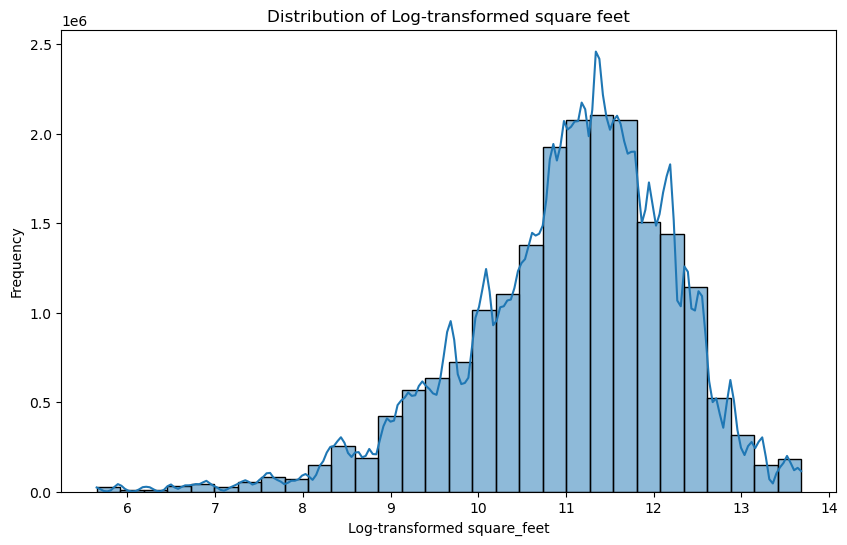

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['square_feet'], bins=30, kde=True)
plt.title('Distribution of Log-transformed square feet')
plt.xlabel('Log-transformed square_feet')
plt.ylabel('Frequency')
plt.show()

## 3.4 Date Breakdown

In [9]:
# Breakdown the datetime

import pandas as pd
import numpy as np

def break_datetime(df, timestamp_col='timestamp'):
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df['hour'] = df[timestamp_col].dt.hour.astype(np.uint8)
    df['dayofweek'] = df[timestamp_col].dt.dayofweek.astype(np.uint8)
    df['month'] = df[timestamp_col].dt.month.astype(np.uint8)
    df['dayofyear'] = df[timestamp_col].dt.dayofyear.astype(np.uint16)
    df['day'] = df[timestamp_col].dt.day.astype(np.uint16)
    df['year'] = df[timestamp_col].dt.year.astype(np.uint16)

    return df

In [10]:
train_df= break_datetime(train_df)

In [25]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
0,0,0,2016-01-01,0.0,0,Education,8.913685,2008.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
1,1,0,2016-01-01,0.0,0,Education,7.908755,2004.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
2,2,0,2016-01-01,0.0,0,Education,8.589886,1991.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
3,3,0,2016-01-01,0.0,0,Education,10.072639,2002.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
4,4,0,2016-01-01,0.0,0,Education,11.666573,1975.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016


## 3.5 Feature Engineering

In [88]:
train_df[train_df['building_id']==1099]['meter_reading'].describe()

count    17566.000000
mean         8.564208
std          3.608276
min          4.976734
25%          6.256500
50%          6.894363
75%          8.854950
max         16.902212
Name: meter_reading, dtype: float64

In [11]:
drop_indices= list(train_df[train_df['building_id']==1099].index)
train_df.drop(drop_indices, axis=0, inplace=True)

In [90]:
print(train_df.meter_reading.max())

13.688103675842285


In [91]:
train_df[train_df['building_id']==778]['meter_reading'].describe()

count    16860.000000
mean         3.487550
std          3.450661
min          0.000000
25%          0.000000
50%          5.066700
75%          5.585844
max         13.688104
Name: meter_reading, dtype: float64

In [12]:
drop_indices= list(train_df[train_df['building_id']==778].index)
train_df.drop(drop_indices, axis=0, inplace=True)

In [13]:
drop_0readings= list(train_df[train_df['meter_reading']==0.0].index)
train_df.drop(drop_0readings, axis=0, inplace=True)

### 3.5.1 Missing Value Imputation

In [14]:
def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 100) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df
missing_value_train= percent_missing_val(train_df)
missing_value_train
train_df.drop(['year_built', 'floor_count'], axis=1,inplace=True)

In [15]:
def nan_fillers(df):
  air_temp_df=df.groupby(['site_id', 'day', 'month'])['air_temperature'].transform('mean')
  df['air_temperature'].fillna(air_temp_df, inplace=True)

  dew_temp_df=df.groupby(['site_id', 'day', 'month'])['dew_temperature'].transform('mean')
  df['dew_temperature'].fillna(dew_temp_df, inplace=True)

  cloud_df=df.groupby(['site_id', 'day', 'month'])['cloud_coverage'].transform('mean')
  df['cloud_coverage'].fillna(cloud_df, inplace=True)

  sea_level_df=df.groupby(['site_id', 'day', 'month'])['sea_level_pressure'].transform('mean')
  df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

  precip_df=df.groupby(['site_id', 'day', 'month'])['precip_depth_1_hr'].transform('mean')
  df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

  wind_dir_df=df.groupby(['site_id', 'day', 'month'])['wind_direction'].transform('mean')
  df['wind_direction'].fillna(wind_dir_df, inplace=True)

  wind_speed_df=df.groupby(['site_id', 'day', 'month'])['wind_speed'].transform('mean')
  df['wind_speed'].fillna(wind_speed_df, inplace=True)


  return df

In [16]:
train_df= nan_fillers(train_df)

In [97]:
train_df.isnull().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
air_temperature             0
cloud_coverage        1222254
dew_temperature             0
precip_depth_1_hr     2676779
sea_level_pressure     822312
wind_direction              0
wind_speed                  0
hour                        0
dayofweek                   0
month                       0
dayofyear                   0
day                         0
year                        0
dtype: int64

In [17]:
train_df['cloud_coverage'].fillna(train_df['cloud_coverage'].median(), inplace=True)
train_df['sea_level_pressure'].fillna(train_df['sea_level_pressure'].median(), inplace=True)
train_df['precip_depth_1_hr'].fillna(train_df['precip_depth_1_hr'].median(), inplace=True)

### 3.5.2 Adding new features

In [18]:
#Adding holiday features
import holidays

location_df= pd.DataFrame()
location_df['site_id']= np.arange(0,16)
location_df['city']= ['Orlando', 'Heathrow', 'Tempe', 'Washington', 'Berkeley', 'Southampton', 'Washington', 'Ottowa', 'Orlando', 'Austin', 'Saltlake',\
                  'Ottowa', 'Dublin', 'Minneapolis', 'Philadelphia', 'Rochestor']

location_df['country']= ['US', 'UK', 'US', 'US', 'US', 'UK', 'US', 'Canada', 'US', 'US', 'US', 'Canada', 'Ireland', 'US', 'US', 'US']
    

In [19]:
train_df=train_df.merge(location_df, on='site_id', how='left')

In [20]:
#geeksforgeeks.org/python-holidays-library/
UK=[]
US=[]
CA=[]
IRE=[]

for ptr in holidays.UnitedKingdom(years = 2016).keys():
    UK.append(str(ptr))
for ptr in holidays.UnitedKingdom(years = 2017).keys():
    UK.append(str(ptr))
for ptr in holidays.UnitedKingdom(years = 2018).keys():
    UK.append(str(ptr))
UK.append('2019-01-01')


for ptr in holidays.UnitedStates(years = 2016).keys():
    US.append(str(ptr))
for ptr in holidays.UnitedStates(years = 2017).keys():
    US.append(str(ptr))
for ptr in holidays.UnitedStates(years = 2018).keys():
    US.append(str(ptr))
US.append('2019-01-01')


for ptr in holidays.Canada(years = 2016).keys():
    CA.append(str(ptr))
for ptr in holidays.Canada(years = 2017).keys():
    CA.append(str(ptr))
for ptr in holidays.Canada(years = 2018).keys():
    CA.append(str(ptr))
CA.append('2019-01-01')


for ptr in holidays.Ireland(years = 2016).keys():
    IRE.append(str(ptr))
for ptr in holidays.Ireland(years = 2017).keys():
    IRE.append(str(ptr))
for ptr in holidays.Ireland(years = 2018).keys():
    IRE.append(str(ptr))
IRE.append('2019-01-01')

In [21]:
def holiday_filler(df):
  df['isHoliday']=[0]*(df.shape[0])
  df.loc[df['country']=='US', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(US)).astype('int')
  df.loc[df['country']=='UK', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(UK)).astype('int')
  df.loc[df['country']=='Canada', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(CA)).astype('int')
  df.loc[df['country']=='Ireland', 'isHoliday']= (df['timestamp'].dt.date.astype('str').isin(IRE)).astype('int')

  return df

In [22]:
train_df= holiday_filler(train_df)

In [23]:
#adding season features
train_df['season']= train_df['timestamp'].apply(lambda x: 'Spring' if x.month==3 or x.month==4 or x.month==5 else 'Summer' if 
                                                x.month==6 or x.month==7 or x.month==8 
                                                else 'Autumn' if x.month==9 or x.month==10 or 
                                                x.month==11 else 'Winter')

In [24]:
#Adding day and night period features
train_df['IsDayTime']= train_df['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)

In [25]:
#Adding relative humidity
train_df['relative_humidity']= 100*((np.exp((17.67*train_df['dew_temperature'])/
                                            (243.5+train_df['dew_temperature'])))/(np.exp((17.67*train_df['air_temperature'])/
                                                                                          (243.5+train_df['air_temperature']))))

In [45]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,...,month,dayofyear,day,year,city,country,isHoliday,season,IsDayTime,relative_humidity
0,46,0,2016-01-01,3.993413,0,Retail,9.110078,25.000000,6.0,20.000000,...,1,1,1,2016,Orlando,US,1,Winter,0,73.780556
1,74,0,2016-01-01,3.784219,0,Parking,12.867830,25.000000,6.0,20.000000,...,1,1,1,2016,Orlando,US,1,Winter,0,73.780556
2,93,0,2016-01-01,3.978196,0,Office,10.415443,25.000000,6.0,20.000000,...,1,1,1,2016,Orlando,US,1,Winter,0,73.780556
3,105,0,2016-01-01,3.190624,1,Education,10.832181,3.800781,0.0,2.400391,...,1,1,1,2016,Heathrow,UK,1,Winter,0,90.566727
4,106,0,2016-01-01,0.318163,1,Education,8.589514,3.800781,0.0,2.400391,...,1,1,1,2016,Heathrow,UK,1,Winter,0,90.566727


In [26]:
train_df.drop(['city','country'], axis=1, inplace=True)

# IV. Model Training

## 4.1 PCA

In [27]:
y_df = train_df['meter_reading']

In [28]:
y_pra_train = y_df

In [29]:
train_df=train_df.sort_values(by='timestamp')

In [30]:
from sklearn.preprocessing import LabelEncoder

label_enc= LabelEncoder()

In [31]:
label_enc.fit(train_df['primary_use'])
train_df['primary_use']= label_enc.transform(train_df['primary_use'])

In [32]:
label_enc.fit(train_df['season'])
train_df['season']= label_enc.transform(train_df['season'])

In [33]:
pca_train = train_df
pca_train.drop(columns='timestamp', inplace=True, axis=1)
pca_train.drop(columns=['building_id', 'site_id'], inplace=True, axis=1)

In [34]:
pca_train.drop(columns=['meter_reading'], inplace=True, axis=1)

In [53]:
pca_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18314942 entries, 0 to 18314941
Data columns (total 20 columns):
 #   Column              Dtype  
---  ------              -----  
 0   meter               int8   
 1   primary_use         int64  
 2   square_feet         float64
 3   air_temperature     float32
 4   cloud_coverage      float32
 5   dew_temperature     float32
 6   precip_depth_1_hr   float32
 7   sea_level_pressure  float32
 8   wind_direction      float32
 9   wind_speed          float32
 10  hour                uint8  
 11  dayofweek           uint8  
 12  month               uint8  
 13  dayofyear           uint16 
 14  day                 uint16 
 15  year                uint16 
 16  isHoliday           int64  
 17  season              int64  
 18  IsDayTime           int64  
 19  relative_humidity   float32
dtypes: float32(8), float64(1), int64(4), int8(1), uint16(3), uint8(3)
memory usage: 1.5 GB


In [35]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()
pca_train_scaled = scaler.fit_transform(pca_train)

In [37]:
pca = PCA() 
principal_components = pca.fit_transform(pca_train_scaled)

In [38]:
result_pca = pd.DataFrame(principal_components[:,:2], columns=['PC1', 'PC2'])

In [39]:
variance_explained = sum(pca.explained_variance_ratio_[:14])
print(variance_explained)

0.9051307926696492


In [40]:
print("Feature names for first two components:")
for i, comp in enumerate(pca.components_[:2]):
    feature_names = pca_train.columns[np.argsort(comp)[::-1][:3]]
    print("Component {}: {}".format(i+1, ", ".join(feature_names)))

Feature names for first two components:
Component 1: season, wind_direction, wind_speed
Component 2: sea_level_pressure, relative_humidity, IsDayTime


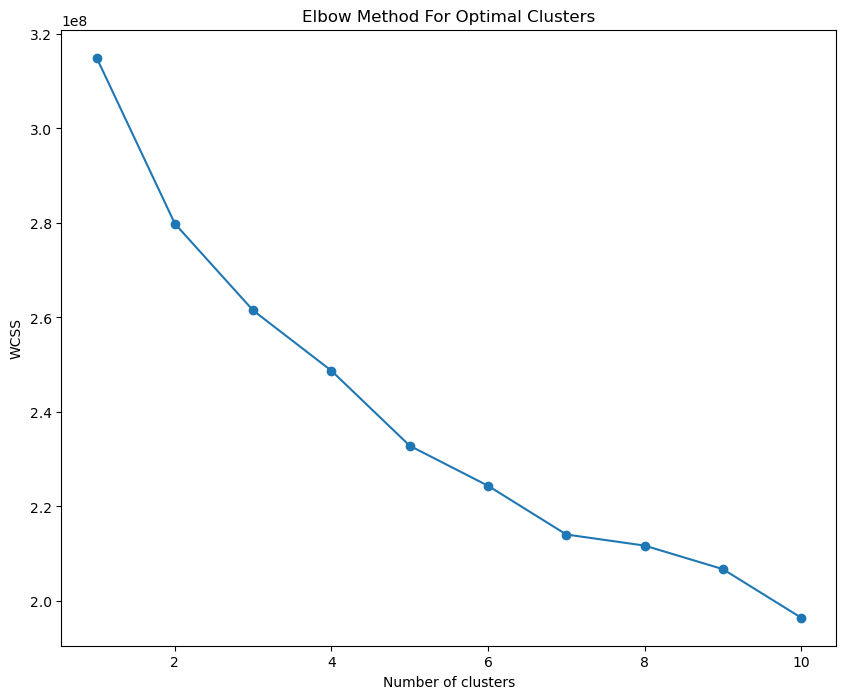

In [41]:
from sklearn.cluster import KMeans
import numpy as np

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(principal_components[:,:14])
    wcss.append(kmeans.inertia_) 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [42]:
import numpy as np
differences = np.diff(wcss)  
largest_drop_index = np.argmin(differences) + 1 
print("The largest drop in WCSS is at cluster number:", largest_drop_index + 1) 

The largest drop in WCSS is at cluster number: 2


In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume your wine data is stored in X
# Perform K-Means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(principal_components)
inertia = kmeans.inertia_
clusters_pca = kmeans.fit_predict(principal_components)
# Get the assigned cluster labels for each cluster
cluster_labels = kmeans.labels_

/Users/victoriashi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/victoriashi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


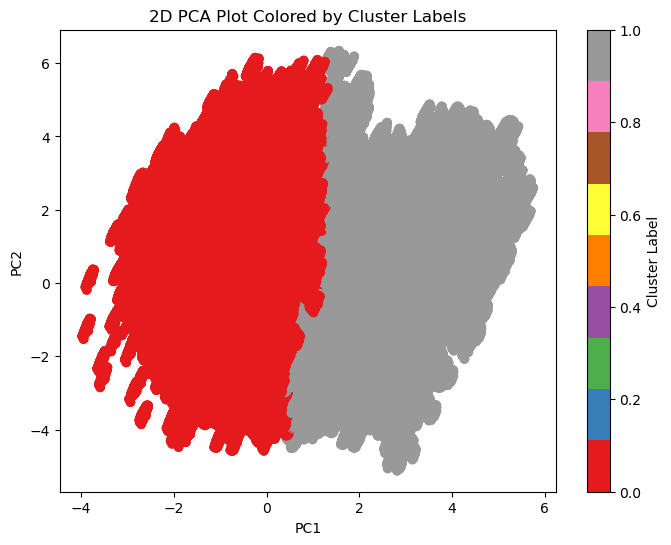

312796185.96375287


In [44]:
import matplotlib.pyplot as plt

# Assuming X_pca_final is your PCA results and cluster_labels are from a clustering algorithm
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, cmap='Set1')  # Use only the first two components
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('2D PCA Plot Colored by Cluster Labels')
plt.colorbar(ax.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, cmap='Set1'), label='Cluster Label')
plt.show()

# Print the inertia if you have calculated it previously in your clustering process
print(inertia)


In [45]:
import pandas as pd

# Assuming pca_train is your original dataset and it's a DataFrame
# Ensure the length of the DataFrame matches the length of the cluster labels
if len(pca_train) == len(cluster_labels):
    pca_train['Cluster_Labels'] = cluster_labels
else:
    print("Mismatch in the number of samples and cluster labels")

# Now pca_train includes the cluster labels as a new column
pca_train['Cluster_Labels'].value_counts()

Cluster_Labels
0    11925121
1     6389821
Name: count, dtype: int64

In [46]:
train_df_2 = pca_train
train_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18314942 entries, 0 to 18314941
Data columns (total 21 columns):
 #   Column              Dtype  
---  ------              -----  
 0   meter               int8   
 1   primary_use         int64  
 2   square_feet         float64
 3   air_temperature     float32
 4   cloud_coverage      float32
 5   dew_temperature     float32
 6   precip_depth_1_hr   float32
 7   sea_level_pressure  float32
 8   wind_direction      float32
 9   wind_speed          float32
 10  hour                uint8  
 11  dayofweek           uint8  
 12  month               uint8  
 13  dayofyear           uint16 
 14  day                 uint16 
 15  year                uint16 
 16  isHoliday           int64  
 17  season              int64  
 18  IsDayTime           int64  
 19  relative_humidity   float32
 20  Cluster_Labels      int32  
dtypes: float32(8), float64(1), int32(1), int64(4), int8(1), uint16(3), uint8(3)
memory usage: 1.6 GB


In [74]:
print(train)

          building_id  meter            timestamp  meter_reading
0                   0      0  2016-01-01 00:00:00       0.000000
1                   1      0  2016-01-01 00:00:00       0.000000
2                   2      0  2016-01-01 00:00:00       0.000000
3                   3      0  2016-01-01 00:00:00       0.000000
4                   4      0  2016-01-01 00:00:00       0.000000
...               ...    ...                  ...            ...
20216095         1444      0  2016-12-31 23:00:00       8.750000
20216096         1445      0  2016-12-31 23:00:00       4.825000
20216097         1446      0  2016-12-31 23:00:00       0.000000
20216098         1447      0  2016-12-31 23:00:00     159.574997
20216099         1448      0  2016-12-31 23:00:00       2.850000

[20216100 rows x 4 columns]


In [47]:
new_df = pd.concat([train_df_2, y_pra_train], axis=1)
new_df_0 = new_df[new_df['Cluster_Labels'] == 0]
new_df_0

,meter,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,...,month,dayofyear,day,year,isHoliday,season,IsDayTime,relative_humidity,Cluster_Labels,meter_reading
3133503,1,6,10.549910,23.296875,2.399726,20.000000,0.0,1005.769531,162.279663,2.599609,...,3,68,8,2016,0,1,1,81.727509,0,5.042082
3133500,0,0,11.259748,23.296875,2.399726,20.000000,0.0,1005.769531,162.279663,2.599609,...,3,68,8,2016,0,1,1,81.727509,0,5.062595
3133498,1,0,10.741406,23.296875,2.399726,20.000000,0.0,1005.769531,162.279663,2.599609,...,3,68,8,2016,0,1,1,81.727509,0,4.833954
3133497,0,0,10.741406,23.296875,2.399726,20.000000,0.0,1005.769531,162.279663,2.599609,...,3,68,8,2016,0,1,1,81.727509,0,3.806663
3133491,0,0,12.968391,23.296875,2.399726,20.000000,0.0,1005.769531,162.279663,2.599609,...,3,68,8,2016,0,1,1,81.727509,0,7.279319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18313486,0,0,10.778018,12.796875,2.000000,3.300781,0.0,1013.500000,30.000000,2.099609,...,12,366,31,2016,0,3,0,52.417076,0,2.772589
18313485,0,0,12.171497,12.796875,2.000000,3.300781,0.0,1013.500000,30.000000,2.099609,...,12,366,31,2016,0,3,0,52.417076,0,4.321533
18313484,0,0,11.363172,12.796875,2.000000,3.300781,0.0,1013.500000,30.000000,2.099609,...,12,366,31,2016,0,3,0,52.417076,0,5.535364
18313498,0,0,12.235898,12.796875,2.000000,3.300781,0.0,1013.500000,30.000000,2.099609,...,12,366,31,2016,0,3,0,52.417076,0,5.942794


In [48]:
new_df_1 = new_df[new_df['Cluster_Labels'] == 1]
new_df_1

,meter,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,...,month,dayofyear,day,year,isHoliday,season,IsDayTime,relative_humidity,Cluster_Labels,meter_reading
0,0,11,9.110078,25.000000,6.0,20.000000,-0.138889,1019.5,0.0,0.000000,...,1,1,1,2016,1,3,0,73.780556,1,3.993413
1150,0,6,12.427046,-8.296875,8.0,-12.203125,-0.217045,1023.5,250.0,4.101562,...,1,1,1,2016,1,3,0,73.422035,1,5.492349
1149,2,8,11.337619,-8.296875,8.0,-12.203125,-0.217045,1023.5,250.0,4.101562,...,1,1,1,2016,1,3,0,73.422035,1,6.482104
1148,1,8,11.337619,-8.296875,8.0,-12.203125,-0.217045,1023.5,250.0,4.101562,...,1,1,1,2016,1,3,0,73.422035,1,1.526643
1147,0,8,11.337619,-8.296875,8.0,-12.203125,-0.217045,1023.5,250.0,4.101562,...,1,1,1,2016,1,3,0,73.422035,1,3.970292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17702747,3,0,11.935313,-19.203125,2.0,-21.000000,0.000000,1034.0,360.0,0.000000,...,12,355,20,2016,0,3,1,85.648598,1,5.488099
17702753,3,0,11.756914,-19.203125,2.0,-21.000000,0.000000,1034.0,360.0,0.000000,...,12,355,20,2016,0,3,1,85.648598,1,5.610131
17702325,3,0,12.867474,-19.203125,2.0,-21.000000,0.000000,1034.0,360.0,0.000000,...,12,355,20,2016,0,3,1,85.648598,1,8.240203
17702323,3,0,13.503462,-19.203125,2.0,-21.000000,0.000000,1034.0,360.0,0.000000,...,12,355,20,2016,0,3,1,85.648598,1,8.944253


In [49]:
y_0 = new_df_0['meter_reading']
X_0 = new_df_0.drop(columns='meter_reading')

In [50]:
y_1 = new_df_1['meter_reading']
X_1 = new_df_1.drop(columns='meter_reading')

In [51]:
# Split zero label
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.2, shuffle=False)
# Split 1 label
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, shuffle=False)

In [52]:
# Split zero label
X_train_00 = X_train_0
X_test_00 = X_test_0
y_train_00 = y_train_0
y_test_00 = y_test_0

X_train_11 = X_train_1
X_test_11 = X_test_1
y_train_11 = y_train_1
y_test_11 = y_test_1

# V. Model 

## 5.1 Decision Tree

In [120]:
# decision trees
import numpy as np
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from joblib import dump
depth = [3, 5, 7, 9, 11, 15]
best_rmse = float('inf')
best_model = None
best_depth = None

for i in depth:
    d_reg = DecisionTreeRegressor(max_depth=i)
    d_reg.fit(X_train_0, y_train_0)
    pred_d_reg = d_reg.predict(X_test_0)

    rmse = math.sqrt(mean_squared_error(y_test_0, pred_d_reg))
    mape = mean_absolute_percentage_error(y_test_0, pred_d_reg)

    print("rmse for max_depth:", i, 'is', rmse)
    print("mape for max_depth:", i, 'is', mape)

    # Check if the current model is better than the best known model
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = d_reg
        best_depth = i

# Save the best model
if best_model is not None:
    model_filename = f'decision_tree_best_model_depth_{best_depth}.joblib'
    dump(best_model, model_filename)
    print(f'Model saved as {model_filename}')
else:
    print("No model was trained.")

rmse for max_depth: 3 is 1.4492059378548987
mape for max_depth: 3 is 5.596050156735494
rmse for max_depth: 5 is 1.4385895958458392
mape for max_depth: 5 is 5.478754982044257
rmse for max_depth: 7 is 1.3599044971244545
mape for max_depth: 7 is 5.1244430610762235
rmse for max_depth: 9 is 1.2712112146929113
mape for max_depth: 9 is 4.680145066813023
rmse for max_depth: 11 is 1.1756669007331528
mape for max_depth: 11 is 0.607367302712044
rmse for max_depth: 15 is 1.0074490084473957
mape for max_depth: 15 is 0.41506493694226054
Model saved as decision_tree_best_model_depth_15.joblib


In [121]:
depth = [3, 5, 7, 9, 11, 15]
best_rmse = float('inf')
best_model = None
best_depth = None

for i in depth:
    d_reg = DecisionTreeRegressor(max_depth=i)
    d_reg.fit(X_train_1, y_train_1)  
    pred_d_reg = d_reg.predict(X_test_1) 

    rmse = math.sqrt(mean_squared_error(y_test_1, pred_d_reg))
    mape = mean_absolute_percentage_error(y_test_1, pred_d_reg)

    print("rmse for max_depth:", i, 'is', rmse)
    print("mape for max_depth:", i, 'is', mape)

    # Check if the current model is better than the best known model
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = d_reg
        best_depth = i

# Save the best model
if best_model is not None:
    model_filename = f'decision_tree_best_model_depth_1_{best_depth}.joblib'
    dump(best_model, model_filename)
    print(f'Model saved as {model_filename}')
else:
    print("No model was trained.")

rmse for max_depth: 3 is 1.4484506465383347
mape for max_depth: 3 is 7.408944474674153
rmse for max_depth: 5 is 1.3305048796599785
mape for max_depth: 5 is 7.493498356919015
rmse for max_depth: 7 is 1.256862882119029
mape for max_depth: 7 is 7.335710881283979
rmse for max_depth: 9 is 1.187517434971681
mape for max_depth: 9 is 7.109106994046662
rmse for max_depth: 11 is 1.1070069013936856
mape for max_depth: 11 is 7.066755555482248
rmse for max_depth: 15 is 0.9438443226193143
mape for max_depth: 15 is 5.254781104772568
Model saved as decision_tree_best_model_depth_1_15.joblib


## 5.2 LightGBM

In [129]:
import numpy as np
import math
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from joblib import dump
import lightgbm as lgb

warnings.filterwarnings('ignore')

lgb_estimators = [75, 150, 500, 1000, 2000]
best_rmse = float('inf')
best_model = None
best_estimators = None

for i in lgb_estimators:
    rf_reg = lgb.LGBMRegressor(
        boosting_type='rf', 
        n_estimators=i, 
        n_jobs=-1, 
        objective='rmse', 
        subsample=0.8, 
        feature_fraction=0.8, 
        bagging_freq=1,
        verbose=-1  
    )
    rf_reg.fit(X_train_0, y_train_0)
    pred_rf_reg = rf_reg.predict(X_test_0)

    rmse = math.sqrt(mean_squared_error(y_test_0, pred_rf_reg))
    mape = mean_absolute_percentage_error(y_test_0, pred_rf_reg)
    
    print("rmse for estimators:", i, 'is', rmse)
    print("mape for estimators:", i, 'is', mape)


    if rmse < best_rmse:
        best_rmse = rmse
        best_model = rf_reg
        best_estimators = i

# Save the best model with a unique name
if best_model is not None:
    model_filename = f'best_rf_model_{best_estimators}_estimators_0.joblib'  # Unique name with dataset identifier "_0"
    dump(best_model, model_filename)
    print(f'Model saved as {model_filename}')
else:
    print("No model was trained.")


rmse for estimators: 75 is 1.377785128757427
mape for estimators: 75 is 5.204086494396617
rmse for estimators: 150 is 1.3721134816844918
mape for estimators: 150 is 5.178226116094385
rmse for estimators: 500 is 1.3730597195228986
mape for estimators: 500 is 5.213580608908678
rmse for estimators: 1000 is 1.3725850517017313
mape for estimators: 1000 is 5.208229317345554
rmse for estimators: 2000 is 1.3720196156486872
mape for estimators: 2000 is 5.203027895493098
Model saved as best_rf_model_2000_estimators_0.joblib


In [126]:
import numpy as np
import math
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from joblib import dump
import lightgbm as lgb

# Suppress Python warnings
warnings.filterwarnings('ignore')

lgb_estimators = [75, 150, 500, 1000, 2000]
best_rmse = float('inf')
best_model = None
best_estimators = None

for i in lgb_estimators:
    rf_reg = lgb.LGBMRegressor(
        boosting_type='rf', 
        n_estimators=i, 
        n_jobs=-1, 
        objective='rmse', 
        subsample=0.8, 
        feature_fraction=0.8, 
        bagging_freq=1,
        verbose=-1  # Set verbosity to -1 to suppress LightGBM's own warnings and informational messages
    )
    rf_reg.fit(X_train_1, y_train_1)  # Use dataset labeled "1"
    pred_rf_reg = rf_reg.predict(X_test_1)  # Use dataset labeled "1"

    rmse = math.sqrt(mean_squared_error(y_test_1, pred_rf_reg))
    mape = mean_absolute_percentage_error(y_test_1, pred_rf_reg)
    
    print("rmse for estimators:", i, 'is', rmse)
    print("mape for estimators:", i, 'is', mape)

    # Update the best model if the current model has a lower RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = rf_reg
        best_estimators = i

# Save the best model with a unique name
if best_model is not None:
    model_filename = f'best_rf_model_{best_estimators}_estimators_1.joblib'  # Unique name with dataset identifier "_1"
    dump(best_model, model_filename)
    print(f'Model saved as {model_filename}')
else:
    print("No model was trained.")


rmse for estimators: 75 is 1.3208566714989196
mape for estimators: 75 is 7.509950073585537
rmse for estimators: 150 is 1.3212314171665294
mape for estimators: 150 is 7.503540322562254
rmse for estimators: 500 is 1.320411766686996
mape for estimators: 500 is 7.514278843322339
rmse for estimators: 1000 is 1.3211173255051258
mape for estimators: 1000 is 7.511030539469853
rmse for estimators: 2000 is 1.3210732319294127
mape for estimators: 2000 is 7.514304218854491
Model saved as best_rf_model_500_estimators_1.joblib


## 5.3 XGBoost

In [130]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
import warnings
from joblib import dump

# Suppress all warnings
warnings.filterwarnings('ignore')

xgb_estimators = [75, 150, 500, 1000, 1500]
best_rmse = float('inf')
best_model = None
best_estimators = None
cv_error_array = []
cv_error_array_1 = []

for n in xgb_estimators:
    xgb_reg = xgb.XGBRegressor(n_estimators=n, verbosity=0)  # Set verbosity to 0 to suppress xgboost warnings
    xgb_reg.fit(X_train_0, y_train_0)
    pred_xgb = xgb_reg.predict(X_test_0)
    rmse = math.sqrt(mean_squared_error(y_test_0, pred_xgb))
    mape = mean_absolute_percentage_error(y_test_0, pred_xgb)
    
    cv_error_array.append(rmse)
    cv_error_array_1.append(mape)
    print("rmse for estimators:", n, 'is', rmse)
    print("mape for estimators:", n, 'is', mape)

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = xgb_reg
        best_estimators = n

if best_model is not None:
    model_filename = f'best_xgb_model_{best_estimators}_estimators_0.joblib'  # Unique name with dataset identifier "_0"
    dump(best_model, model_filename)
    print(f'Model saved as {model_filename}')
else:
    print("No model was trained.")


rmse for estimators: 75 is 1.0181919816325782
mape for estimators: 75 is 3.127748
rmse for estimators: 150 is 0.9633274596331118
mape for estimators: 150 is 2.304313
rmse for estimators: 500 is 0.8990601745299601
mape for estimators: 500 is 1.2122135
rmse for estimators: 1000 is 0.8887325056583503
mape for estimators: 1000 is 1.147453
rmse for estimators: 1500 is 0.8972194874003027
mape for estimators: 1500 is 1.1213838
Model saved as best_xgb_model_1000_estimators_0.joblib


In [131]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
import warnings
from joblib import dump

# Suppress all warnings
warnings.filterwarnings('ignore')

xgb_estimators = [75, 150, 500, 1000, 1500]
best_rmse = float('inf')
best_model = None
best_estimators = None
cv_error_array = []
cv_error_array_1 = []

for n in xgb_estimators:
    xgb_reg = xgb.XGBRegressor(n_estimators=n, verbosity=0)  # Set verbosity to 0 to suppress xgboost warnings
    xgb_reg.fit(X_train_1, y_train_1)  # Use dataset labeled "1"
    pred_xgb = xgb_reg.predict(X_test_1)  # Use dataset labeled "1"
    rmse = math.sqrt(mean_squared_error(y_test_1, pred_xgb))
    mape = mean_absolute_percentage_error(y_test_1, pred_xgb)
    
    cv_error_array.append(rmse)
    cv_error_array_1.append(mape)
    print("rmse for estimators:", n, 'is', rmse)
    print("mape for estimators:", n, 'is', mape)

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = xgb_reg
        best_estimators = n

if best_model is not None:
    model_filename = f'best_xgb_model_{best_estimators}_estimators_1.joblib'  # Unique name with dataset identifier "_1"
    dump(best_model, model_filename)
    print(f'Model saved as {model_filename}')
else:
    print("No model was trained.")


rmse for estimators: 75 is 0.9969143647460671
mape for estimators: 75 is 5.52238
rmse for estimators: 150 is 0.9405407864712355
mape for estimators: 150 is 4.7367706
rmse for estimators: 500 is 0.8611675640456147
mape for estimators: 500 is 3.1635025
rmse for estimators: 1000 is 0.8530213345434446
mape for estimators: 1000 is 2.8599017
rmse for estimators: 1500 is 0.863193386664083
mape for estimators: 1500 is 2.5131009
Model saved as best_xgb_model_1000_estimators_1.joblib


## 5.4 MLP

MAPE for logistic activation: 1.4004796972223483
MAPE for relu activation: 1.9529103144093558


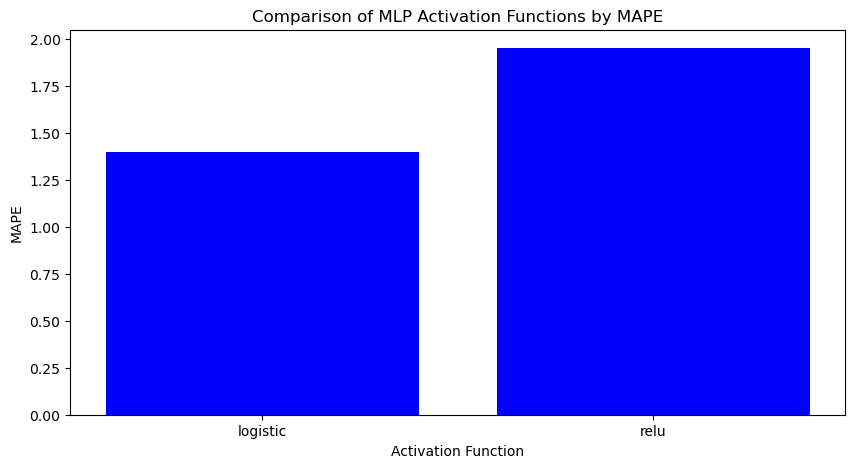

In [53]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump

scaler = StandardScaler()
X_train_0 = scaler.fit_transform(X_train_0)
X_test_0 = scaler.transform(X_test_0)

activation_functions = ['logistic', 'relu']
mape_results = {}
for activation in activation_functions:
    mlp = MLPRegressor(hidden_layer_sizes=(32, 64, 32, 16), activation=activation, random_state=42, max_iter=500)
    mlp.fit(X_train_0, y_train_0)
    
    y_pred = mlp.predict(X_test_0)
    mape = mean_absolute_percentage_error(y_test_0, y_pred)
    mape_results[activation] = mape

for activation, mape in mape_results.items():
    print(f"MAPE for {activation} activation: {mape}")

plt.figure(figsize=(10, 5))
plt.bar(mape_results.keys(), mape_results.values(), color='blue')
plt.xlabel('Activation Function')
plt.ylabel('MAPE')
plt.title('Comparison of MLP Activation Functions by MAPE')
plt.show()


In [ ]:
scaler = StandardScaler()
X_train_1 = scaler.fit_transform(X_train_1)
X_test_1 = scaler.transform(X_test_1)

activation_functions = ['logistic', 'relu']
mape_results = {}
for activation in activation_functions:
    mlp = MLPRegressor(hidden_layer_sizes=(32, 64, 32, 16), activation=activation, random_state=42, max_iter=500)
    mlp.fit(X_train_1, y_train_1)
    
    y_pred = mlp.predict(X_test_1)
    mape = mean_absolute_percentage_error(y_test_1, y_pred)
    mape_results[activation] = mape

for activation, mape in mape_results.items():
    print(f"MAPE for {activation} activation: {mape}")

plt.figure(figsize=(10, 5))
plt.bar(mape_results.keys(), mape_results.values(), color='blue')
plt.xlabel('Activation Function')
plt.ylabel('MAPE')
plt.title('Comparison of MLP Activation Functions by MAPE')
plt.show()
